In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!sh "/content/drive/MyDrive/Colab Notebooks/image_duplicate/copy_to_root.sh"

Streaming output truncated to the last 5000 lines.
tar: Ignoring unknown extended header keyword 'hdrcharset'
tar: Ignoring unknown extended header keyword 'hdrcharset'
tar: Ignoring unknown extended header keyword 'hdrcharset'
tar: Ignoring unknown extended header keyword 'hdrcharset'
tar: Ignoring unknown extended header keyword 'hdrcharset'
tar: Ignoring unknown extended header keyword 'hdrcharset'
tar: Ignoring unknown extended header keyword 'hdrcharset'
tar: Ignoring unknown extended header keyword 'hdrcharset'
tar: Ignoring unknown extended header keyword 'hdrcharset'
tar: Ignoring unknown extended header keyword 'hdrcharset'
tar: Ignoring unknown extended header keyword 'hdrcharset'
tar: Ignoring unknown extended header keyword 'hdrcharset'
tar: Ignoring unknown extended header keyword 'hdrcharset'
tar: Ignoring unknown extended header keyword 'hdrcharset'
tar: Ignoring unknown extended header keyword 'hdrcharset'
tar: Ignoring unknown extended header keyword 'hdrcharset'
tar: 

In [3]:
pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 14.2 MB/s 


# MODEL 5 - MobileNetV3 with feature vector euclidian distance

- Use relu
- Loss: BinaryCrossentropy


In [6]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os

import pandas as pd
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
from tensorflow.python.data import AUTOTUNE
from tensorflow.keras import layers as kl
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks as cb
import tensorflow_addons as tfa

from src.math.euclidian_distance import euclidian_distance
from src.nn.activations.hard_swish import hard_swish
from src.nn.layers.image_resize_fit import ResizeImageToFit
from src.nn.losses.contrastive_loss import contrastive_loss
from src.nn.layers.euclidian_distance import EuclidianDistance


if os.getcwd().startswith("/Users"): os.chdir(os.getcwd().split("/notebooks", 1)[0])

from src.config.notebook_config import NotebookConfig

from src.evaluation.evaluation import Evaluation

from src.data.utility.tf_dataset_transformer import TfDatasetTransformer


%load_ext autoreload
%autoreload 2

# Config

In [7]:
MODEL_NAME = "model_5"

import src.data.dataset.dataset_v3_loader as dataset_loader # V3
DATASET_LOADER = dataset_loader

config = NotebookConfig(MODEL_NAME, dataset_loader.dataset_name())

BATCH_SIZE = 128

print(config.summary())

Model: model_5
Output: /content/drive/MyDrive/Colab Notebooks/image_duplicate/output/model_5_v3
Output for Tensorboard: /content/drive/MyDrive/Colab Notebooks/image_duplicate/output/tensorboard/model_5_v3
Saved model path: /content/drive/MyDrive/Colab Notebooks/image_duplicate/models/model_5_v3

Image shape: <src.data.dataset.image_shape.ImageShape object at 0x7f42647f5790>



# Data Loading

In [8]:
train_dataset = DATASET_LOADER.load_train_v3()
val_dataset = DATASET_LOADER.load_validation_v3()

In [9]:
pair_tuples = list(map(lambda pair: (pair.image_a, pair.image_b, pair.similar), train_dataset.image_pairs))
pair_array = np.array(pair_tuples)

tf_dataset_transformer =  TfDatasetTransformer(image_shape=config.image_shape, rescale=False)

train_tf_dataset = tf_dataset_transformer.transform_to_tf_dataset(train_dataset, shuffle=True, batch_size=BATCH_SIZE, cache_path="./tf_cache/train_dataset")
val_tf_dataset = tf_dataset_transformer.transform_to_tf_dataset(val_dataset, shuffle=False, batch_size=128, cache_path="./tf_cache/val_dataset")

# Model

In [18]:
def create_common_model() -> keras.Model:
    mobnet = keras.applications.MobileNetV3Large(input_shape=config.image_shape.to_shape(), include_top=False, pooling="avg", dropout_rate=0.2)
    mobnet.trainable = False

    input = keras.Input(shape=(None, None, 3))
    x = ResizeImageToFit(height=config.image_shape.height, width=config.image_shape.width)(input)
    x = mobnet(x, training=False)
    x = kl.Dense(1280, activation="relu")(x)
    return keras.Model(inputs=input, outputs=x)


def create_model() -> keras.Model:
    input_a = keras.Input(shape=(None, None, 3))
    input_b = keras.Input(shape=(None, None, 3))

    common_model = create_common_model()

    print(common_model.summary())

    layer_a = common_model(input_a)
    layer_b = common_model(input_b)

    merge_layer = EuclidianDistance()([layer_a, layer_b])
    #merge_layer = kl.Lambda(euclidian_distance)([layer_a, layer_b])
    merge_layer = kl.Dense(1, activation="sigmoid")(merge_layer)

    return keras.Model(inputs=[input_a, input_b], outputs=merge_layer, name=MODEL_NAME)


lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=727, decay_rate=0.75)
metric_f1_micro = tfa.metrics.f_scores.F1Score(num_classes=1, average="micro", name="f1-micro")

model = create_model()
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_schedule), loss=losses.BinaryCrossentropy(), metrics=["accuracy", metric_f1_micro])

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 resize_image_to_fit_4 (Resi  (None, 224, 224, 3)      0         
 zeImageToFit)                                                   
                                                                 
 MobilenetV3large (Functiona  (None, 960)              2996352   
 l)                                                              
                                                                 
 dense_8 (Dense)             (None, 1280)              1230080   
                                                                 
Total params: 4,226,432
Trainable params: 1,230,080
Non-trainable params: 2,996,352
_________________________________________________________________
None
Model: "model_5"
___________________

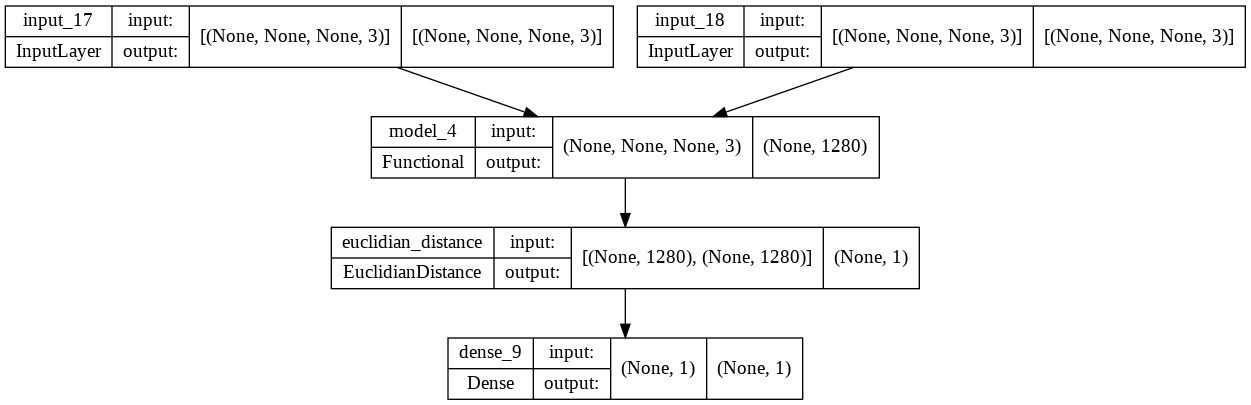

In [19]:
keras.utils.plot_model(model, show_shapes=True, expand_nested=False)

In [10]:
save_cb = cb.ModelCheckpoint(config.model_output_path, save_best_only=True)
tensorboard_cb = cb.TensorBoard(log_dir=config.tensorboard_log_dir)

In [21]:
save_cb = cb.ModelCheckpoint(config.model_output_path, save_best_only=True)
tensorboard_cb = cb.TensorBoard(log_dir=config.tensorboard_log_dir)


history = model.fit(train_tf_dataset, epochs=40, workers=8, max_queue_size=20, validation_data=val_tf_dataset, callbacks=[save_cb, tensorboard_cb])

pd.DataFrame(history.history).plot()

AttributeError: ignored

In [11]:
model: keras.Model = keras.models.load_model(config.model_output_path)


In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.02 , decay_steps=999, decay_rate=0.9)
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_schedule), loss=losses.BinaryCrossentropy(), metrics=["accuracy"])

history = model.fit(train_tf_dataset, epochs=90, workers=8, max_queue_size=20, validation_data=val_tf_dataset, callbacks=[tensorboard_cb, save_cb], initial_epoch=49)
pd.DataFrame(history.history).plot()

Epoch 50/90
999/999 [==============================] - 824s 819ms/step - loss: 0.0462 - accuracy: 0.9844 - val_loss: 0.0584 - val_accuracy: 0.9800
Epoch 51/90
999/999 [==============================] - 794s 794ms/step - loss: 0.0339 - accuracy: 0.9886 - val_loss: 0.0635 - val_accuracy: 0.9789
Epoch 52/90
999/999 [==============================] - 792s 793ms/step - loss: 0.0276 - accuracy: 0.9911 - val_loss: 0.0659 - val_accuracy: 0.9788
Epoch 53/90
999/999 [==============================] - 794s 795ms/step - loss: 0.0234 - accuracy: 0.9925 - val_loss: 0.0663 - val_accuracy: 0.9789
Epoch 54/90
999/999 [==============================] - 797s 798ms/step - loss: 0.0208 - accuracy: 0.9936 - val_loss: 0.0692 - val_accuracy: 0.9779
Epoch 55/90
999/999 [==============================] - 796s 797ms/step - loss: 0.0185 - accuracy: 0.9947 - val_loss: 0.0720 - val_accuracy: 0.9779
Epoch 56/90
999/999 [==============================] - 796s 796ms/step - loss: 0.0166 - accuracy: 0.9954 - val_loss: 0

In [ ]:
import gc
gc.collect(2)#%%

559

# Evaluation

In [ ]:
a = 6
a

6

In [ ]:
model: keras.Model = keras.models.load_model(config.saved_model_path)

In [12]:
evaluation = Evaluation(dataset=val_dataset, image_shape=config.image_shape, model=model)
iter = evaluation.tf_dataset.as_numpy_iterator()

461/461 [==============================] - 135s 271ms/step
              precision    recall  f1-score   support

       False       0.96      0.89      0.93     13405
        True       0.92      0.97      0.94     16086

    accuracy                           0.93     29491
   macro avg       0.94      0.93      0.93     29491
weighted avg       0.94      0.93      0.93     29491

Regular pairs:
              precision    recall  f1-score   support

       False       1.00      0.89      0.94     13405
        True       0.65      1.00      0.79      2681

    accuracy                           0.91     16086
   macro avg       0.83      0.95      0.87     16086
weighted avg       0.94      0.91      0.92     16086

Augmented pairs:
              precision    recall  f1-score   support

       False       0.00      0.00      0.00         0
        True       1.00      0.96      0.98     13405

    accuracy                           0.96     13405
   macro avg       0.50      0.48    

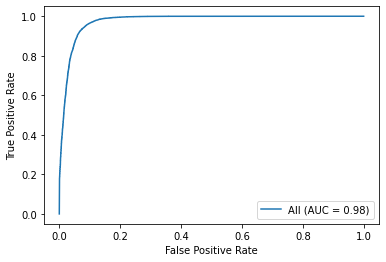

In [13]:
# before training a bit more.
evaluation.print_f1_report(threshold=0.5)
evaluation.print_separate_f1_reports(threshold=0.5)
evaluation.plot_roc()

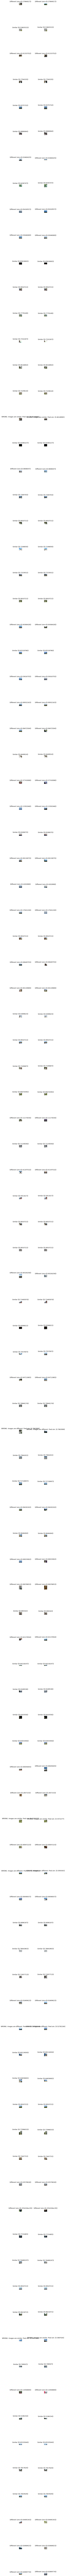

In [14]:
evaluation.show_images(range(8000, 8100))